## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import warnings
from pyzipcode import ZipCodeDatabase

/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Reading in the data

In [2]:
# import data
df_king_county = pd.read_csv('../data/King_County_House_prices_dataset.csv')

## Inspecting the data

In [3]:
df_king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df_king_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df_king_county.shape

(21597, 21)

## The data contains 21597 houses sold from 2014-05-02 till 2015-05-27. 

In [6]:
df_king_county.date.min()


'1/10/2015'

In [7]:
df_king_county.date.max()

'9/9/2014'

## The features are: <br>
* id - unique identified for a house
* date - house was sold
* price - is prediction target
* bedrooms - # of bedrooms
* bathrooms - # of bathrooms
* sqft_living - footage of the home
* sqft_lot - footage of the lot
* floors - floors (levels) in house
* waterfront - House which has a view to a waterfront
* view - Has been viewed
* condition - How good the condition is ( Overall )
* grade - overall grade given to the housing unit, based on King County grading system
* sqft_above - square footage of house apart from basement
* sqft_basement - square footage of the basement
* yr_built - Built Year
* yr_renovated - Year when house was renovated
* zipcode - zip
* lat - Latitude coordinate
* long - Longitude coordinate
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


## Cleaning the data

In [8]:
#In column date change type object to type datetime
df_king_county['date'] = pd.to_datetime(df_king_county['date'])

#in column sqft_basement change dtype object to float. Apparently this column contains also 454 '?'s, so these have to be replaced.
df_king_county.sqft_basement.value_counts()
df_king_county.sqft_basement = df_king_county.sqft_basement.replace('?', '0')
df_king_county.sqft_basement =  df_king_county.sqft_basement.astype(float)

In [9]:
#check for nans in the entire DataFrame
# waterfroont, view and yr_renovated have nans
for col in df_king_county.columns: 
    if  df_king_county[col].isnull().values.any(): print(col)

waterfront
view
yr_renovated


In [10]:
#waterfront has values 0 and 1, so replace Nans by 0
df_king_county['waterfront'].isnull().sum()   
df_king_county['waterfront'].value_counts()
df_king_county.waterfront.fillna(0, inplace=True)

In [11]:
#view has values from 0 to 4, so replace nans by o
df_king_county['view'].value_counts()
df_king_county.view.fillna(0, inplace=True)

In [12]:
#df_king_county.yr_renovated.isnull().sum()
df_king_county.yr_renovated.value_counts()
df_king_county.yr_renovated.fillna(0, inplace = True)


## Oldest date a house was renovated : 1934

In [13]:
df_oldest_house = df_king_county[df_king_county.yr_renovated !=0]    
print(df_oldest_house.yr_renovated.min())

1934.0


## The most expensive house was sold in 98102 Seattle for 7 700 000 $
## The cheapest house was sold in 98168 Seattle for 78 K $

In [14]:
# function to convert Zipcodes to City names
def get_location(code):
    zcdb = ZipCodeDatabase()
    zipcode = zcdb[code]
    return zipcode.city


In [15]:
df_king_county.price.min()
df_king_county.query('price == 78000')
get_location(98168)

'Seattle'

In [16]:
df_king_county.price.max()
df_king_county.query('price == 7700000')
get_location(98102)

'Seattle'

## Distribution of price

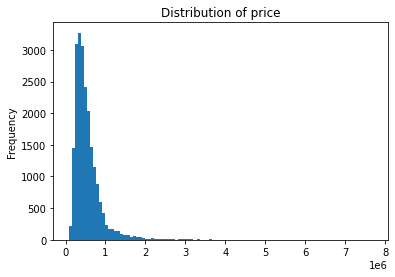

In [17]:
plt.hist(df_king_county.price, bins=100)
plt.gca().set(title='Distribution of price', label= 'Price', ylabel='Frequency');


## The prices are right skewed. Since the Stakeholder is not looking for houses in the highest price segments, these can be removed from tha data. Then the prices are more normal distributed.

In [18]:
df_king_county_cut = df_king_county.drop(df_king_county[df_king_county.price > 2500000].index)
df_king_county.shape

(21597, 21)

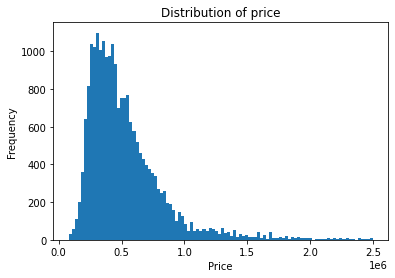

In [19]:
plt.hist(df_king_county_cut.price, bins=100)
plt.gca().set(title='Distribution of price', xlabel= 'Price', ylabel='Frequency');


# Hypothesis 1: Seasons might influence the price, summer could be the best time to buy

## Comparison of average prices over months

Text(0.5, 1.0, 'Average prices per month')

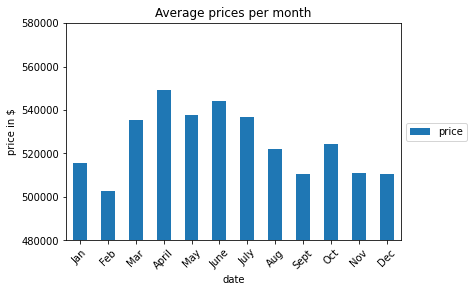

In [20]:
# add column price per sqft
df_king_county_cut.eval('sqft_price = price / sqft_living', inplace=True)  
df_king_county_cut.sqft_price = df_king_county_cut.sqft_price.apply(lambda x: round(x, 2)) 


#what month had the lowest average price?
#change date to months only
df_months = df_king_county_cut.copy()
df_months.date = df_king_county_cut.date.dt.month

df_month_mean = df_months.groupby('date').mean().price
labels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

df = pd.DataFrame({'date': labels,'price': df_month_mean.values})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'price', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(480000, 580000)
plt.title('Average prices per month')

## Comparison of average prices in May 2014 and May 2015

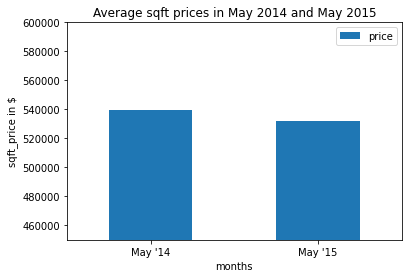

In [21]:
mask_may14 = (df_king_county_cut['date'] < '2014-06-01')
a = df_king_county_cut.price.loc[mask_may14].mean()

mask_may15 = (df_king_county_cut['date'] < '2015-06-01') & (df_king_county_cut['date'] >= '2015-05-01')
b = df_king_county_cut.price.loc[mask_may15].mean()

dict_may = {'months': ["May '14", "May '15"], 'price': [a,b]}

df_may = pd.DataFrame.from_dict(dict_may)
df_may.head()

fig_may = df_may.plot(kind='bar', x = 'months', y = 'price')
plt.xticks(rotation = 0)
plt.ylabel('sqft_price in $')
plt.ylim(450000, 600000)
plt.title('Average sqft prices in May 2014 and May 2015');


## Comparison of average sqft prices over months

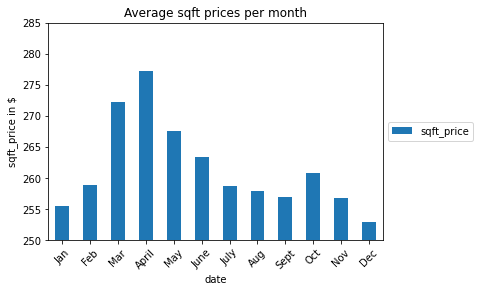

In [22]:
df_month_mean = df_months.groupby('date').mean().sqft_price
df2 = pd.DataFrame({'date': labels,'sqft_price': df_month_mean.values})
ax2 = plt.subplot()
fig2 = df2.plot(kind = 'bar', x = 'date', y = 'sqft_price',ax = ax2)
plt.xticks(rotation =45)
plt.ylabel('sqft_price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(250, 285)
plt.title('Average sqft prices per month');


## How many houses are sold every month?

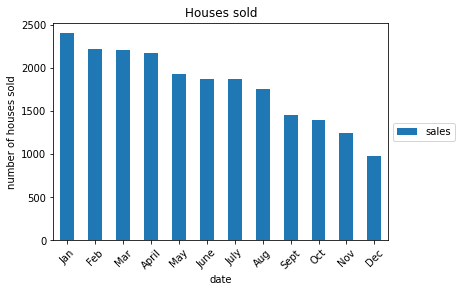

In [23]:
df = pd.DataFrame({'date': labels,'sales': df_months.date.value_counts()})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'sales', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('number of houses sold')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Houses sold')
ax;


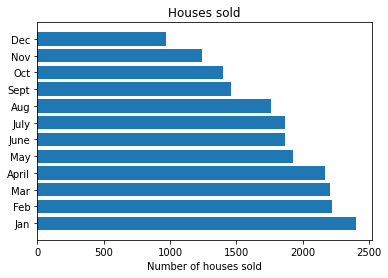

In [24]:
plt.barh(y=df.date, width=df.sales)
plt.title('Houses sold')
plt.xlabel('Number of houses sold');

# Hypothesis 2: High grade houses are sold at higher price 

## Grade has values from 3 to 13.

In [25]:
d=df_king_county_cut[['grade', 'price']]
d.sort_values('grade')  
df_king_county_cut.grade.min()
df_king_county_cut.grade.max()


13


## Many outliers. My stakeholder is looking for cheap houses, so I will delete for every grade the expensive houses.

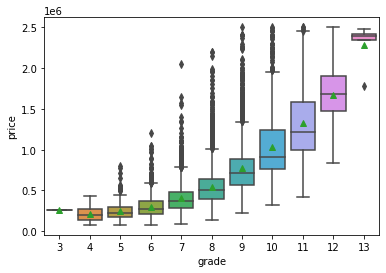

In [26]:
# grade vs price
sns.boxplot(x='grade', y = 'price', data=df_king_county_cut, showmeans = True);

In [27]:
# remove outliers for grade 5 to 12
# remove outliers that more than one standard deviation away from the mean
for i in range(5, 13): 
   df_outliers = df_king_county_cut.query('grade=={}'.format(i))
   mean = df_outliers.price.mean()
   standard_dev = np.std(df_outliers.price)
   #df_king_county_cut = df_king_county_cut.drop(df_king_county_cut[(df_king_county_cut.price > 1.5*mean) & (df_king_county_cut.grade == i)].index)
   df_king_county_cut = df_king_county_cut.drop(df_king_county_cut[(df_king_county_cut.price > standard_dev+mean) & (df_king_county_cut.grade == i)].index)

Without the outliers the grade price relation looks more linear.

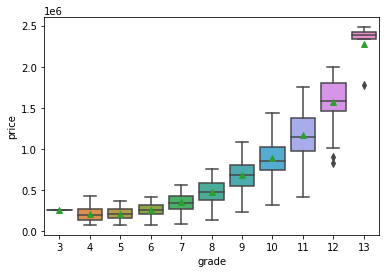

In [28]:
# grade vs price
sns.boxplot(x='grade', y = 'price', data=df_king_county_cut, showmeans = True);

Grade vs price as Linechart

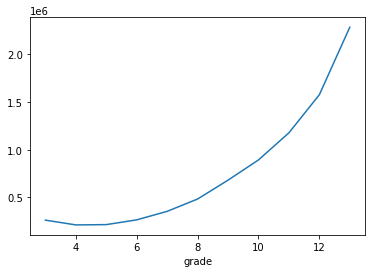

In [29]:
df_king_county_cut.groupby('grade').price.mean().plot();

## Fit OLS model

In [30]:
#create OLS model
X = df_king_county_cut.grade
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.136e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        01:18:36   Log-Likelihood:            -2.4618e+05
No. Observations:               18519   AIC:                         4.924e+05
Df Residuals:                   18517   BIC:                         4.924e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.771e+05   7099.020   -109.463      0.000   -7.91e+05   -7.63e+05
grade       1.626e+05    918.236    177.090      0.000    1.61e+05    1.64e+05
==============================================================================
Omnibus:                     1814.987   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4758.009
Skew:                           0.563   Prob(JB):                         0.00
Kurtosis:                       5.213   Cond. No.                         52.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plotting the result of the linear regression, i.e. regression line.

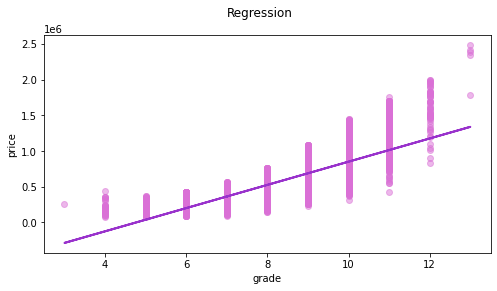

In [31]:

intercept, slope = results.params

fig, ax = plt.subplots(figsize=(8, 4))
x = df_king_county_cut.grade
# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Regression')
# plotting regression line
ax.plot(x, x*slope +intercept, '-', color='darkorchid', linewidth=2);
ax.set_ylabel("price");
ax.set_xlabel("grade");

## Every extra point in grade costs about 170K $

In [32]:
slope

162610.3183505142

## Plotting the residuals

eval_env: 1


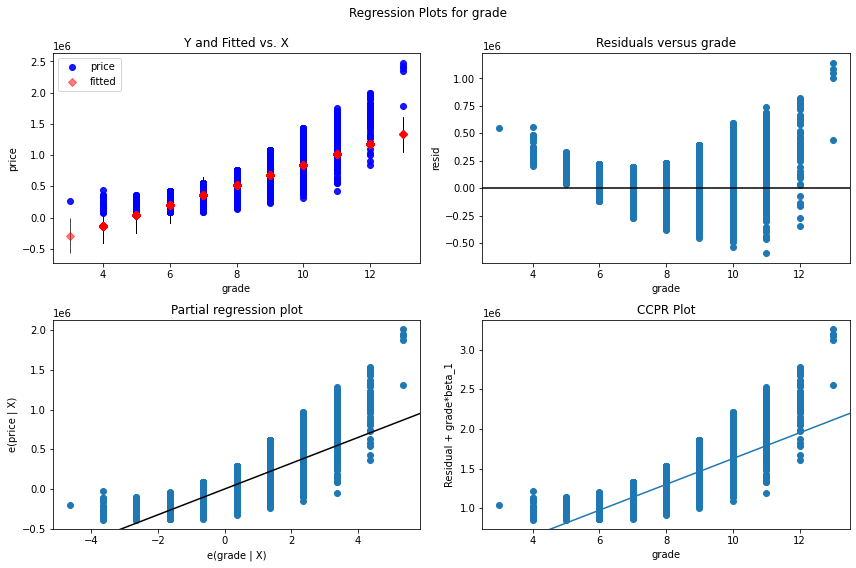

In [33]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'grade', fig=fig)



## There is a weak linear relationship between grade and price. The residuals are not randomly distributed. One feature is not enough to make a good prediction on the price. 
## The heatmap  and the pairchart below show that there a six features that have a high correlation with the price: 
* bathrooms
* sqft_living
* grade
* sqft_above
* sqft_living15
* sqft_price

'sqft_price' can not be used for regression, because of the collinearity with 'price'.
'sqft_above' is highly correlated with 'sqft_living', the correlation is above 0.8, so I will drop 'sqft_above' from the features. 

/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_1766/2121976054.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_heatmap = df_king_county_cut.drop('id',1)
/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_1766/2121976054.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))


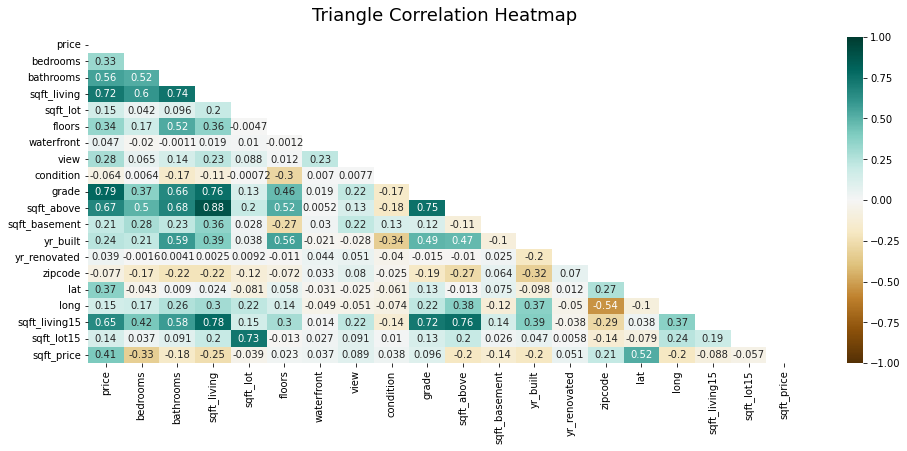

In [34]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
df_heatmap = df_king_county_cut.drop('id',1)
mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_heatmap.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

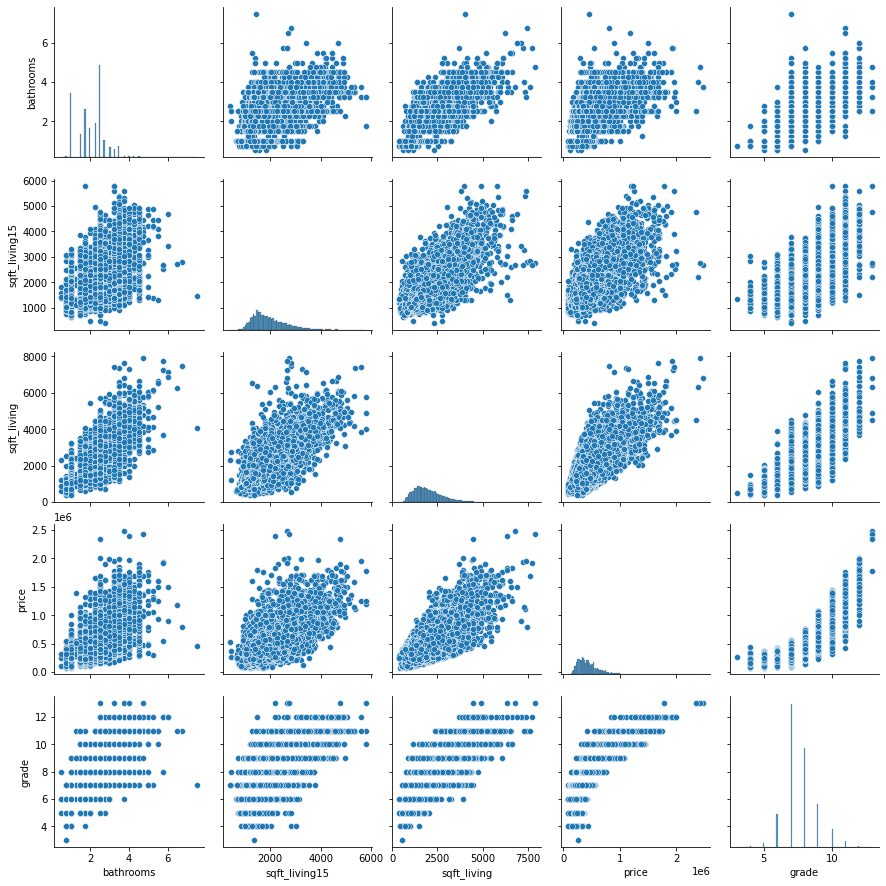

In [35]:
x_columns = ['bathrooms','sqft_living15', 'sqft_living', 'price', 'grade']
sns.pairplot(df_king_county_cut[x_columns]);

## Creating OLS model with  4 features. The result is a little better than the regression with only one feature, grade. 
## The R-squared is 0.66 vs 0.62.

In [36]:
#create OLS model
X = df_king_county_cut[['bathrooms', 'sqft_living15', 'grade', 'sqft_living']]
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     9203.
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        01:18:40   Log-Likelihood:            -2.4522e+05
No. Observations:               18519   AIC:                         4.904e+05
Df Residuals:                   18514   BIC:                         4.905e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.901e+05   7990.465    -73.852      0.000   -6.06e+05   -5.74e+05
bathrooms     -2.187e+04   2081.471    -10.509      0.000    -2.6e+04   -1.78e+04
sqft_living15    14.1783      2.519      5.628      0.000       9.240      19.116
grade          1.186e+05   1462.167     81.099      0.000    1.16e+05    1.21e+05
sqft_living      83.3129      2.372     35.127      0.000      78.664      87.962
==============================================================================
Omnibus:                     1663.483   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4430.273
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       5.164   Cond. No.                     2.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Plot Residuals against bathroom

eval_env: 1


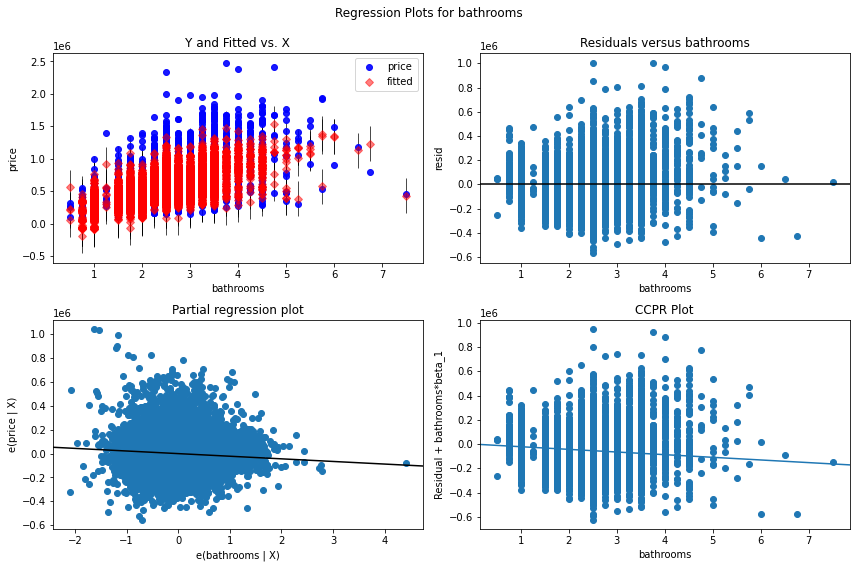

In [37]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'bathrooms', fig=fig)

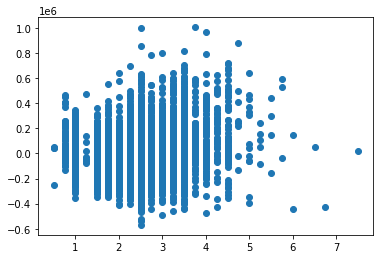

In [38]:
plt.scatter(results.model.exog[:,1], results.resid);

## Plot - Residuals against all features used in the regression model.

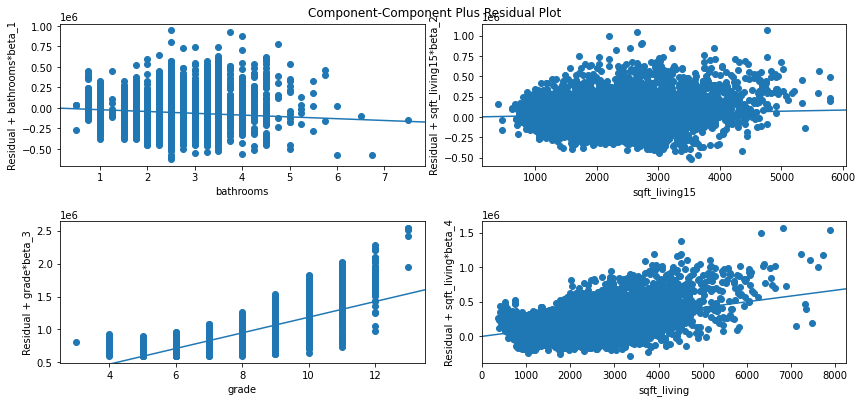

In [39]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(results, fig=fig)

## What are the average houseprices depending on number of bathroom? 

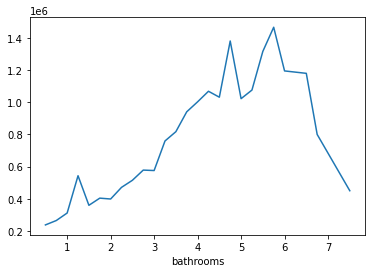

In [40]:
df_king_county_cut.groupby('bathrooms').price.mean().plot();

In average the more bathrooms the higher the house price. Only houses with number of bathrooms between 7 and 8 have a downpeak in price. In the histogram below you can see that there is only one house that has 7.5 bathrooms.

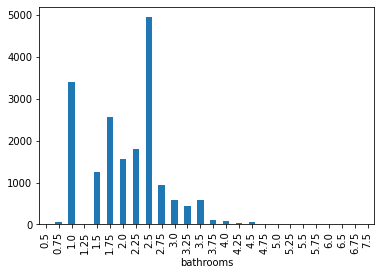

In [41]:
df_bathr = df_king_county_cut.groupby('bathrooms').id.count()
df_bathr.shape
df_bathr.plot(kind='bar');


In [42]:
b = df_king_county_cut.query('bathrooms > 4.5')

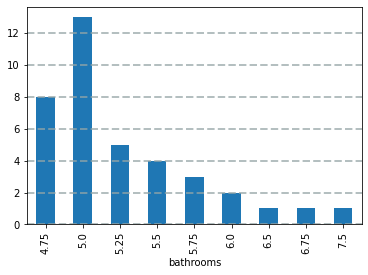

In [43]:
df_bathr2 = df_king_county_cut.query('bathrooms > 4.5').groupby('bathrooms').id.count().plot(kind='bar')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)

In [44]:
df_king_county_cut.bathrooms.unique()

array([1.  , 2.25, 2.  , 4.5 , 1.5 , 2.5 , 1.75, 3.  , 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 4.25, 5.  , 1.25, 3.75, 0.5 , 5.5 , 5.25, 6.75,
       5.75, 7.5 , 6.5 , 6.  ])

In [45]:
df_king_county_cut[df_king_county_cut['bathrooms']>=6].sort_values(by = ['bathrooms']).head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_price
21034,2424059170,2015-02-19,900000.0,5,6.00,7120,40806,2.0,0.0,4.0,...,5480,1640.0,2007,0.0,98006,47.5451,-122.114,3440,36859,126.40
21328,8835770170,2014-08-22,1490000.0,5,6.00,6880,279968,2.0,0.0,3.0,...,4070,2810.0,2007,0.0,98045,47.4624,-121.779,4690,256803,216.57
20562,424069279,2015-03-28,1180000.0,6,6.50,6260,10955,2.0,0.0,0.0,...,4840,1420.0,2007,0.0,98075,47.5947,-122.039,2710,12550,188.50
4020,9175600025,2014-10-07,800000.0,7,6.75,7480,41664,2.0,0.0,2.0,...,5080,2400.0,1953,0.0,98166,47.4643,-122.368,2810,33190,106.95
8537,424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0.0,0.0,...,4050,0.0,1996,0.0,98144,47.5923,-122.301,1448,3866,111.11


In [46]:
df_king_county_cut[df_king_county_cut['bathrooms']>6][['grade','bathrooms']]

,grade,bathrooms
4020,11,6.75
8537,7,7.50
20562,11,6.50


The house with 7.5 bathrooms has only grade 7 which is bad compared to grade of the other houses with more than 6 bathrooms that have grads 11 and 12. This house does also have a lower sqft price, so probably it is not in
too good condition, and also it doesn't have a basement and it is small, since sqft_living is also smaller compared to the other houses with that many bathrooms.

Sqft_living and sqft_living15 also seem to have a linear relationship to the price. I won't analyse that in detail here now.

# Hypothesis 3: Prices rely on the area, i.e. Zipcode

## Converting zipcodes to citynames. There are 70 zipcodes in the dataframe.

In [47]:
df_king_county_cut.groupby('zipcode').count()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_price
zipcode,,,,,,,,,,,,,,,,,,,,,
98001,361,361,361,361,361,361,361,361,361,361,...,361,361,361,361,361,361,361,361,361,361
98002,199,199,199,199,199,199,199,199,199,199,...,199,199,199,199,199,199,199,199,199,199
98003,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
98004,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
98005,121,121,121,121,121,121,121,121,121,121,...,121,121,121,121,121,121,121,121,121,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,214,214,214,214,214,214,214,214,214,214,...,214,214,214,214,214,214,214,214,214,214
98178,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
98188,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136


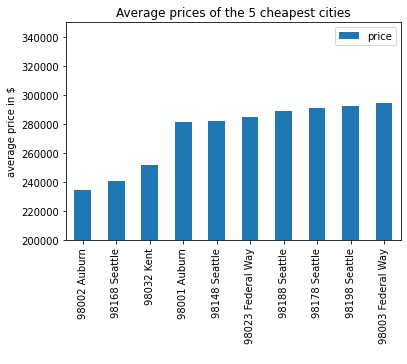

In [48]:
b = df_king_county_cut.groupby('zipcode').price.mean().sort_values().head(10)
  
dfb = pd.DataFrame({'zipcode': [str(z)+' '+get_location(z) for z in b.index], 'price': b.values})
axb = plt.subplot()
figb = dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=90)
plt.ylabel('average price in $')
plt.title('Average prices of the 5 cheapest cities')
plt.ylim(200000,350000)
plt.xlabel(' ');


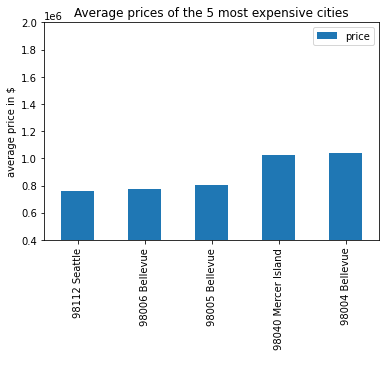

In [49]:
b = df_king_county_cut.groupby('zipcode').price.mean().sort_values().tail()
dfb = pd.DataFrame({'zipcode': [str(z)+' '+get_location(z) for z in b.index],  'price': b.values})
axb = plt.subplot()
figb = dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=90)
plt.ylabel('average price in $')
plt.title('Average prices of the 5 most expensive cities')
get_location(98001)
plt.xlabel(' ')
plt.ylim(400000,2000000);



## Prices rely also on the location, does the house have a waterfront or not.

In [50]:
a= df_king_county.query('waterfront==1').price.mean()
a

1717214.7260273972

In [51]:
b=df_king_county.query('waterfront==0').price.mean()
b

532286.2219943126

Text(0.5, 0, '')

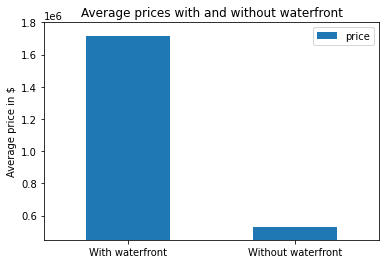

In [52]:
dict_may = {'months': ["With waterfront", "Without waterfront"], 'price': [a,b]}

df_may = pd.DataFrame.from_dict(dict_may)
df_may.head()

fig_may = df_may.plot(kind='bar', x = 'months', y = 'price')
plt.xticks(rotation = 0)
plt.ylabel('Average price in $')
plt.ylim(450000, 1800000)
plt.title('Average prices with and without waterfront')
plt.xlabel('')



## Comparing prices in different zipcodes regarding waterfront.

Text(0, 0.5, 'price in $')

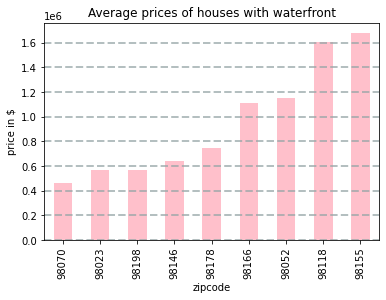

In [53]:
df_king_county_cut.query('waterfront==1').groupby('zipcode').price.mean().sort_values().tail(10).plot(kind='bar',title="Average prices of houses with waterfront", color='pink')
#plt.ylim(1500000,2400000)
#plt.grid()
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.ylabel('price in $')


<AxesSubplot:title={'center':'Average price of houses without waterfront'}, xlabel='zipcode'>

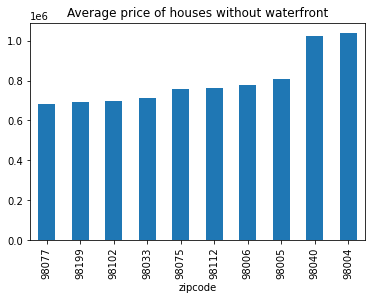

In [54]:
df_king_county_cut.query('waterfront==0').groupby('zipcode').price.mean().sort_values().tail(10).plot(kind='bar', title="Average price of houses without waterfront")

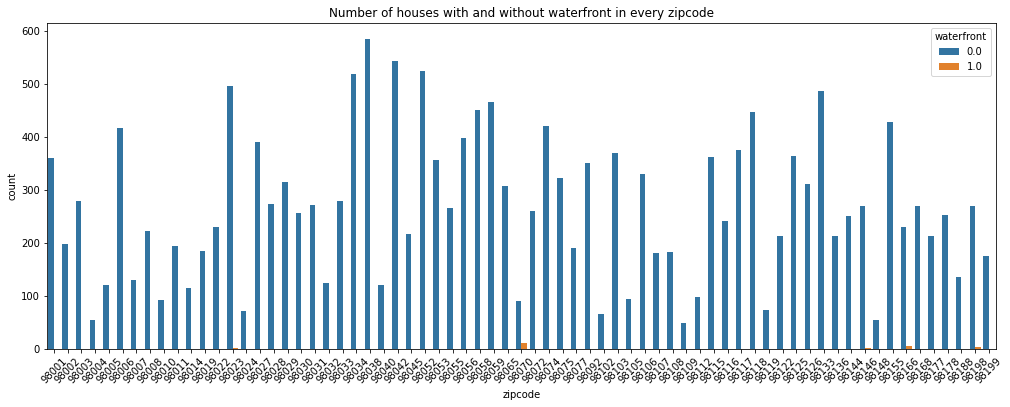

In [55]:
plt.figure(figsize = (17,6))
ax = sns.countplot(x="zipcode", hue="waterfront", data=df_king_county_cut)
plt.title('Number of houses with and without waterfront in every zipcode')
plt.xticks(rotation = 45);

In [56]:
# only 146 houses have a waterfront, 21451 don't have a waterfront.
houses_no_wfr = df_king_county_cut.query('waterfront==0').count()
houses_wfr = df_king_county_cut.query('waterfront==1').count()

# In which Zipcodes / Cities are the houses with waterfront?

/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_1766/69293379.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_waterfront=df_king_county_cut[df_king_county['waterfront']==1]


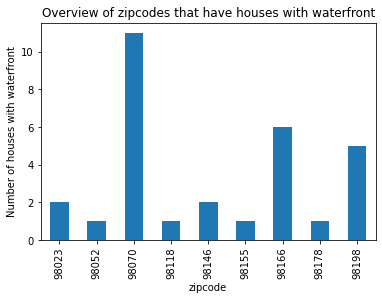

In [57]:
df_waterfront=df_king_county_cut[df_king_county['waterfront']==1]
df_waterfront.groupby('zipcode').waterfront.count().plot(kind='bar')
plt.title('Overview of zipcodes that have houses with waterfront')
plt.ylabel('Number of houses with waterfront');

In [58]:
# in which zipcodes are houses with waterfront
zip = df_king_county_cut.query('waterfront==1')
zip_list = zip.groupby('zipcode').count().index
zip_list


Int64Index([98023, 98052, 98070, 98118, 98146, 98155, 98166, 98178, 98198], dtype='int64', name='zipcode')

# Conclusions and recommendations for my stakeholder
1. End of the year the house prices and the sqft_prices are lowest in average, and also fewer houses are sold. So that time of the year could be good to find a cheap house. <br>
2. Buy houses with lower grade and fewer bathrooms, as well as smaller size in terms of sqft_living, sqft_living15, and sqft_above.<br>
3. Location wise 98002 Auburn, 98168 Seattle, and 98032 Kent are good cities to find cheap houses, and also in general houses without a waterfront.
    No need to look for a house in 98004 Bellevue, and 
   98039 Medina, since this are the most expensive cities.
